In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB





In [3]:
# Basic preprocessing
def preprocess(df):
    df_new = df.copy()
    
    # Discard identifiers, style information, timestamps
    df_new = df_new[df_new.columns.difference(['image', 'style', 'reviewTime', 
                                               'reviewerID', 'asin', 'reviewerName', 'unixReviewTime'])]

    # Turn category into binary features
    for cat in df_new.category.unique():
        df_new[cat] = df_new['category'] == cat

    # Drop category column
    df_new.drop(columns=['category'], inplace=True)

    # NaN vote is 0 users found helpful
    df_new.vote.fillna(0, inplace=True)
    
    # Turn vote into binary feature
    df_new.vote = df_new.vote > 0
    # df_new.vote.clip(0, 10)
    # df_new.vote = df_new.vote / 10

    # NaN summary is empty summary
    df_new.summary.fillna('', inplace=True)

    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [4]:
# Remove 'overall' column and add cutoff column applying cutoff
def apply_cutoff(df, cutoff):
    df_new = df.copy()
    
    # Apply cutoff
    cut = df['overall'] > cutoff
    df_new['cutoff'] = cut

    # Drop overall and category
    df_new.drop(columns=['overall'], inplace=True)
    
    # Turn Booleans into binary variables
    df_new.replace({False: 0, True: 1}, inplace=True)
    
    return df_new

In [5]:
def apply_tfidf(df, review_vectorizer, summary_vectorizer):
    review_matrix = pd.DataFrame(data=review_vectorizer.transform(df.reviewText).toarray(), columns='R_' + review_vectorizer.get_feature_names_out())
    summary_matrix = pd.DataFrame(data=summary_vectorizer.transform(df.summary).toarray(), columns='S_' + summary_vectorizer.get_feature_names_out())
    df_new = pd.concat([df, review_matrix, summary_matrix], axis=1)
    df_new.drop(columns=['summary', 'reviewText'], inplace=True)
    return df_new

In [6]:
training_df = pd.read_csv('../data/Training.csv')
test_df = pd.read_csv('../data/Test.csv')

# Processing the data - I

In [7]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 1)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [8]:
X

,verified,vote,automotive,CDs,grocery,cell_phones,sports,toys,R_00,R_000,...,S_zest,S_zest far,S_zest far inferior,S_zimmer,S_zipper,S_zippers,S_zoom,S_zz,S_zz greatest,S_zz greatest hits
0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
relcols

Index(['verified', 'vote', 'R_00', 'R_08', 'R_10 bucks', 'R_12', 'R_15',
       'R_1970', 'R_1970s', 'R_1973',
       ...
       'S_wtf', 'S_year old', 'S_young', 'S_yuck', 'S_yucky', 'S_yuk', 'S_yum',
       'S_yummy', 'S_zero', 'S_zero stars'],
      dtype='object', length=4272)

In [10]:
# We will go with these columns.
X = X[relcols]

In [11]:
# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [12]:
# Hyperparameter selection on one split
import sys
sys.path.append("..")
from mechanism.mechanized_models import Mechanism
from mechanism.mechanized_models import MechanizedGridSearchCV
from mechanism.mechanized_models import MechanizedDecisionTree

        

X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)

params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}

gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT, cv=2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)

gs_DT.fit(X_train, y_train)
gs_DT.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END ...criterion=entropy, max_depth=40;, score=0.601 total time= 2.4min
[CV 2/2] END ...criterion=entropy, max_depth=40;, score=0.614 total time= 2.2min
[CV 1/2] END ...criterion=entropy, max_depth=52;, score=0.602 total time= 2.3min
[CV 2/2] END ...criterion=entropy, max_depth=52;, score=0.615 total time= 2.0min
[CV 1/2] END ...criterion=entropy, max_depth=64;, score=0.603 total time= 2.2min
[CV 2/2] END ...criterion=entropy, max_depth=64;, score=0.623 total time= 1.9min
[CV 1/2] END ...criterion=entropy, max_depth=76;, score=0.603 total time= 2.1min
[CV 2/2] END ...criterion=entropy, max_depth=76;, score=0.616 total time= 1.9min
[CV 1/2] END ...criterion=entropy, max_depth=88;, score=0.599 total time= 2.1min
[CV 2/2] END ...criterion=entropy, max_depth=88;, score=0.618 total time= 1.9min
[CV 1/2] END ......criterion=gini, max_depth=40;, score=0.616 total time= 2.1min
[CV 2/2] END 

{'criterion': 'gini', 'max_depth': 52}

In [13]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6463030584289964
  Accuracy: 0.8307639602603631
  ROC/AUC score: 0.6946212243294914
Split 1:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6761740953902824
  Accuracy: 0.854230900993491
  ROC/AUC score: 0.687818199663865
Split 2:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6638542143571249
  Accuracy: 0.8311065433367592
  ROC/AUC score: 0.6924286166120251
Split 3:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.653640578283681
  Accuracy: 0.842069201781432
  ROC/AUC score: 0.6431451378684081
Split 4:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6637008359361275
  Accuracy: 0.839814973445263
  ROC/AUC score: 0.6924691701403689
Average F1 score: 0.6607345564792424
Average accuracy: 0.8395971159634616
Average ROC/AUC score: 0.6820964697228317


Text(50.722222222222214, 0.5, 'True label')

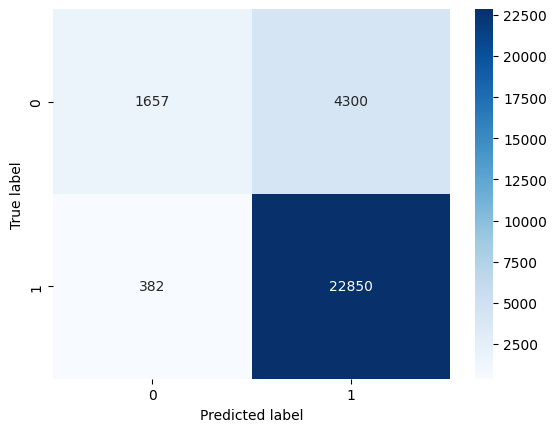

In [14]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

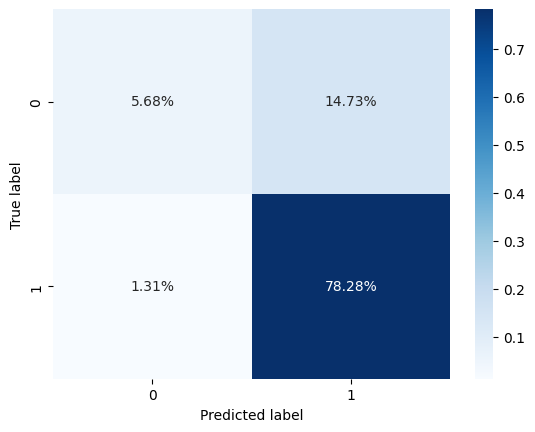

In [15]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [16]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedDecisionTree


MechanizedDecisionTree(max_depth=52)

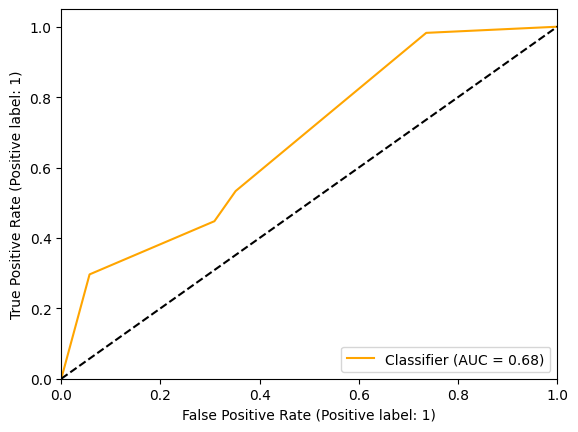

In [17]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [18]:
model1 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model1.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [19]:
# # Extra testing
# (X_train, X_val, y_train, y_val) = splits[np.argmax(f1_scores) % 5]
# f1_score(y_val, (model2.predict_proba(X_val) >= 0.7)[:, 1].astype(int), average='macro')

In [20]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [21]:
# Predict on test and save as .csv
# proc_test_df['predicted'] = model1.predict(proc_test_df)
proc_test_df['predicted'] = (model1.predict_proba(proc_test_df) >= 0.7)[:, 1].astype(int) # yields better F1 score!
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task11.csv', index=False)

# Processing data - II

In [22]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 2)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [23]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT,  cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END ...criterion=entropy, max_depth=40;, score=0.567 total time= 2.7min
[CV 2/2] END ...criterion=entropy, max_depth=40;, score=0.573 total time= 2.5min
[CV 1/2] END ...criterion=entropy, max_depth=52;, score=0.568 total time= 2.7min
[CV 2/2] END ...criterion=entropy, max_depth=52;, score=0.575 total time= 2.5min
[CV 1/2] END ...criterion=entropy, max_depth=64;, score=0.569 total time= 3.8min
[CV 2/2] END ...criterion=entropy, max_depth=64;, score=0.570 total time= 2.6min
[CV 1/2] END ...criterion=entropy, max_depth=76;, score=0.569 total time= 2.7min
[CV 2/2] END ...criterion=entropy, max_depth=76;, score=0.568 total time= 2.6min
[CV 1/2] END ...criterion=entropy, max_depth=88;, score=0.567 total time= 3.0min
[CV 2/2] END ...criterion=entropy, max_depth=88;, score=0.572 total time= 2.8min
[CV 1/2] END ......criterion=gini, max_depth=40;, score=0.565 total time= 2.4min
[CV 2/2] END 

{'criterion': 'entropy', 'max_depth': 52}

In [24]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.5389898240570858
  Accuracy: 0.632408359027064
  ROC/AUC score: 0.6205651675222208
Split 1:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.6284014927034313
  Accuracy: 0.6723192874272012
  ROC/AUC score: 0.7046082542111098
Split 2:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.5547975456679552
  Accuracy: 0.6555327166837959
  ROC/AUC score: 0.646509142785851
Split 3:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.5436260498173511
  Accuracy: 0.6505652620760535
  ROC/AUC score: 0.6301334516084767
Split 4:
in gaussian mechanism MechanizedDecisionTree
  F1 score: 0.5365921187642688
  Accuracy: 0.5922562960424875
  ROC/AUC score: 0.582104434467664
Average F1 score: 0.5604814062020185
Average accuracy: 0.6406163842513204
Average ROC/AUC score: 0.6367840901190644


Text(50.722222222222214, 0.5, 'True label')

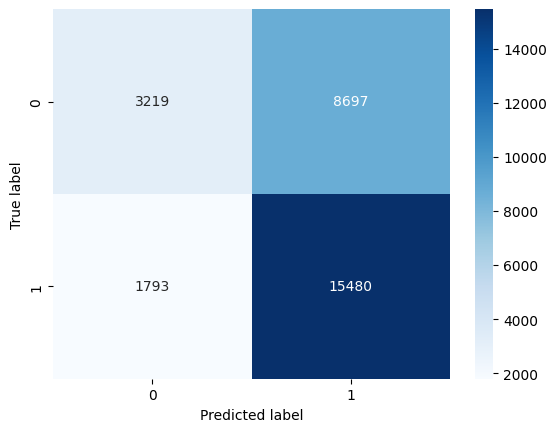

In [25]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(50.722222222222214, 0.5, 'True label')

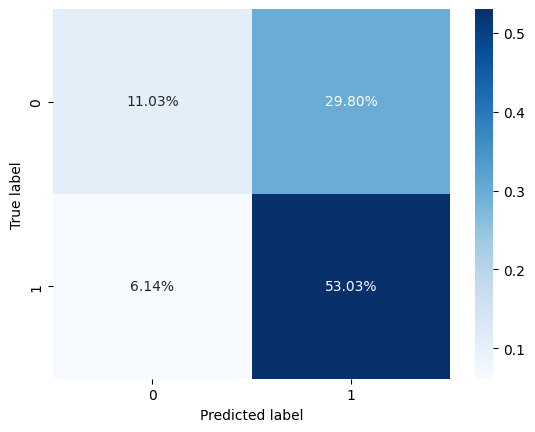

In [26]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [27]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

in gaussian mechanism MechanizedDecisionTree


MechanizedDecisionTree(criterion='entropy', max_depth=52)

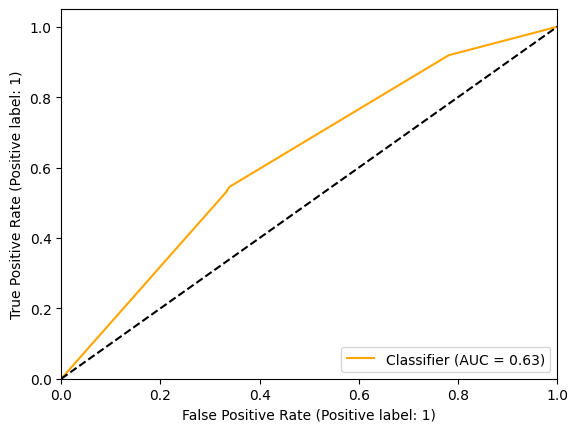

In [28]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [29]:
model2 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model2.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [30]:
# # Extra testing
# (X_train, X_val, y_train, y_val) = splits[np.argmax(f1_scores) % 5]
# f1_score(y_val, (model2.predict_proba(X_val) >= 0.54)[:, 1].astype(int), average='macro')

In [31]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [32]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model2.predict(proc_test_df)
# proc_test_df['predicted'] = (model2.predict_proba(proc_test_df) >= 0.54)[:, 1].astype(int) # yields better F1 score!
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task12.csv', index=False)

# Processing the data - II

In [33]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 3)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [34]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT,  cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

in gaussian mechanism GridSearchCV
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END ...criterion=entropy, max_depth=40;, score=0.575 total time= 3.6min
[CV 2/2] END ...criterion=entropy, max_depth=40;, score=0.576 total time= 4.9min
[CV 1/2] END ...criterion=entropy, max_depth=52;, score=0.566 total time= 5.8min
[CV 2/2] END ...criterion=entropy, max_depth=52;, score=0.564 total time= 4.1min
[CV 1/2] END ...criterion=entropy, max_depth=64;, score=0.559 total time= 5.1min
[CV 2/2] END ...criterion=entropy, max_depth=64;, score=0.566 total time= 4.0min
[CV 1/2] END ...criterion=entropy, max_depth=76;, score=0.562 total time= 4.4min


In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.6964286545159137
  Accuracy: 0.7166837958204865
  ROC/AUC score: 0.6929747783138203
Split 1:
  F1 score: 0.7075734017935197
  Accuracy: 0.7281603288797533
  ROC/AUC score: 0.6968208232927531
Split 2:
  F1 score: 0.6953663022529277
  Accuracy: 0.7158273381294964
  ROC/AUC score: 0.6825747551393442
Split 3:
  F1 score: 0.6802179453600354
  Accuracy: 0.7019527235354573
  ROC/AUC score: 0.6621711679596989
Split 4:
  F1 score: 0.6940791849663427
  Accuracy: 0.7145794072297413
  ROC/AUC score: 0.6819709005903037
Average F1 score: 0.7853993115993955
Average accuracy: 0.7975262473395816
Average ROC/AUC score: 0.8293062224516525


Text(33.0, 0.5, 'True label')

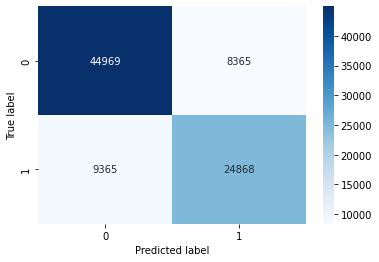

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

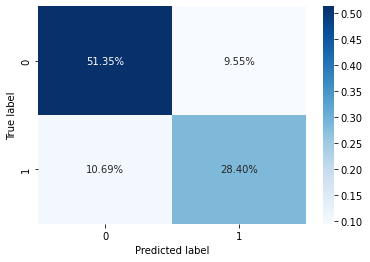

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=76)

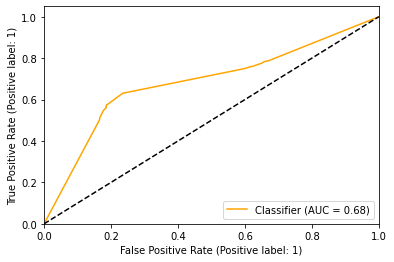

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
# This model seems to perform better on the public test data.
model3 = LogisticRegression(C=5.011872336272722, max_iter=1500)
model3.fit(X, y)

LogisticRegression(C=5.011872336272722, max_iter=1500)

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model3.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task13.csv', index=False)

# Processing the data - IV

In [ ]:
# Preprocessing of training data
proc_training_df = apply_cutoff(preprocess(training_df), 4)

# Set cutoff to be the label; define X and y accordingly
X = proc_training_df.drop('cutoff', axis=1)
y = proc_training_df['cutoff']

# Fit TF-IDF vectorizer for 'reviewText' and 'summary' features, creating max. 11500 features.
r_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
s_vectorizer = TfidfVectorizer(max_features=11500, stop_words='english', ngram_range=(1, 3))
r_vectorizer.fit(X.reviewText)
s_vectorizer.fit(X.summary)

# Apply TF-IDF vectorization 
X = apply_tfidf(X, r_vectorizer, s_vectorizer)

# Apply robust scaling
scaler = preprocessing.RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Let us reduce the number of features by eliminating the statistically least correlated ones.
relcols = X.columns[abs(X.corrwith(y)) > 0.01]
X = X[relcols]

# 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = []
for train_idx, val_idx in kf.split(X, y):
    # Apply split
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reset indices
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    splits.append((X_train, X_val, y_train, y_val))
f1_scores, acc_scores, roc_auc_scores, conf_matrices, models = [], [], [], [], []

## Mechanized Decision Tree Classifier

In [ ]:
# Hyperparameter selection on one split
X_train, X_val, y_train, y_val = splits[0]
gs_cls = MechanizedDecisionTree()
gs_cls.choose_mechanism(Mechanism.GAUSSIAN)
params_DT = {'criterion': ['entropy','gini'], 'max_depth': np.arange(40, 100, 12)}
gs_DT = MechanizedGridSearchCV(estimator=gs_cls, param_grid=params_DT,  cv = 2, verbose=3, scoring='f1_macro')
gs_DT.choose_mechanism(Mechanism.GAUSSIAN)
gs_DT.fit(X_train, y_train)
gs_DT.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ...criterion=entropy, max_depth=40;, score=0.605 total time=   3.7s
[CV 2/3] END ...criterion=entropy, max_depth=40;, score=0.657 total time=   3.8s
[CV 3/3] END ...criterion=entropy, max_depth=40;, score=0.639 total time=   3.8s
[CV 1/3] END ...criterion=entropy, max_depth=52;, score=0.627 total time=   3.9s
[CV 2/3] END ...criterion=entropy, max_depth=52;, score=0.641 total time=   4.4s
[CV 3/3] END ...criterion=entropy, max_depth=52;, score=0.637 total time=   4.5s
[CV 1/3] END ...criterion=entropy, max_depth=64;, score=0.624 total time=   4.5s
[CV 2/3] END ...criterion=entropy, max_depth=64;, score=0.656 total time=   4.8s
[CV 3/3] END ...criterion=entropy, max_depth=64;, score=0.643 total time=   4.9s
[CV 1/3] END ...criterion=entropy, max_depth=76;, score=0.623 total time=   4.7s
[CV 2/3] END ...criterion=entropy, max_depth=76;, score=0.647 total time=   5.3s
[CV 3/3] END ...criterion=entropy, max_depth=76;

{'criterion': 'entropy', 'max_depth': 64}

In [ ]:
# Let us now compute performance metrics.
for i, (X_train, X_val, y_train, y_val) in enumerate(splits):
    print(f"Split {i}:")
    # Train model
    model = MechanizedDecisionTree(**gs_DT.best_params_)
    model.choose_mechanism(Mechanism.GAUSSIAN)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    # Compute and append f1, accuracy, confusion matrix; 
    f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    acc_scores.append(accuracy_score(y_val, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val, y_proba[:, 1]))
    print(f"  F1 score: {f1_scores[-1]}")
    print(f"  Accuracy: {acc_scores[-1]}")
    print(f"  ROC/AUC score: {roc_auc_scores[-1]}")
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    models.append(model)
print(f"Average F1 score: {np.average(f1_scores)}")
print(f"Average accuracy: {np.average(acc_scores)}")
print(f"Average ROC/AUC score: {np.average(roc_auc_scores)}")

Split 0:
  F1 score: 0.6523665371612433
  Accuracy: 0.8019869818430969
  ROC/AUC score: 0.6626486067196735
Split 1:
  F1 score: 0.6441563090580416
  Accuracy: 0.8004453579993148
  ROC/AUC score: 0.6504445860572645
Split 2:
  F1 score: 0.657025903771099
  Accuracy: 0.8054128126070572
  ROC/AUC score: 0.6803041347365605
Split 3:
  F1 score: 0.6405512532578507
  Accuracy: 0.7944501541623844
  ROC/AUC score: 0.6623286545206735
Split 4:
  F1 score: 0.6464387506364196
  Accuracy: 0.7971560733253383
  ROC/AUC score: 0.6517112034282079
Average F1 score: 0.7296739456069602
Average accuracy: 0.8374843305560646
Average ROC/AUC score: 0.8160599663725313


Text(33.0, 0.5, 'True label')

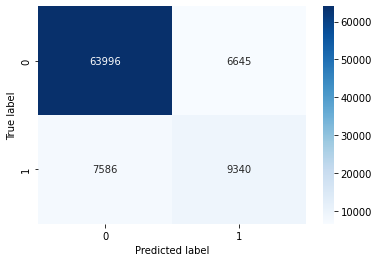

In [ ]:
sns.heatmap(sum(conf_matrices), annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted label'); plt.ylabel('True label')

Text(33.0, 0.5, 'True label')

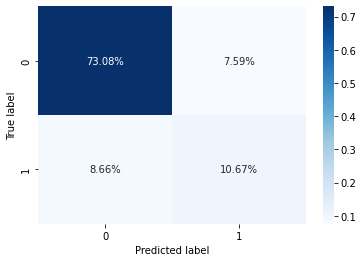

In [ ]:
# With percentages instead
sns.heatmap(sum(conf_matrices)/np.sum(sum(conf_matrices)), 
            annot=True, cmap="Blues", fmt=".2%")
plt.xlabel('Predicted label'); plt.ylabel('True label')

In [ ]:
# Training on a new 80-20 split to draw ROC curve
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
model = MechanizedDecisionTree(**gs_DT.best_params_)
model.choose_mechanism(Mechanism.GAUSSIAN)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=64)

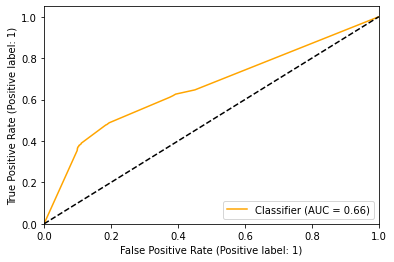

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_val, model.predict_proba(X_val)[:, 1], color='orange')
plt.xlim([0, 1]); plt.ylim([0, 1.05])
plt.plot([0, 1], [0, 1], 'k--')

Time to pick the best model, predict on test and save.

In [ ]:
# This model seems to perform better on the public test data.
model4 = LogisticRegression(C=10.7977516232771, max_iter=1500)
model4.fit(X, y)

LogisticRegression(C=10.7977516232771, max_iter=1500)

In [ ]:
# Preprocessing
proc_test_df = apply_tfidf(preprocess(test_df), r_vectorizer, s_vectorizer)
proc_test_df = pd.DataFrame(scaler.transform(proc_test_df), columns=proc_test_df.columns, index=proc_test_df.index)[relcols]

In [ ]:
# Predict on test and save as .csv
proc_test_df['predicted'] = model4.predict(proc_test_df)
proc_test_df = proc_test_df.reset_index()[['index', 'predicted']]
proc_test_df.rename(columns={'index': 'id'}).to_csv('task14.csv', index=False)